In [107]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import stats 
import networkx.algorithms.community
import igraph as ig
import leidenalg
import copy
import time

## Functions

### Measures

In [108]:
def power_method(A, v_0, sensitivity=1e-6, max_iter=1000):

    '''Function for finding the dominant eigen value (if it exits) for a matrix and also the
    corresponding eigen vector'''

    A = np.array(A, dtype=float)
    v_0 = np.array(v_0, dtype=float)
    v_0 = v_0 / np.linalg.norm(v_0)
    old_vector = v_0
    residuals = []
    iterations = 0

    while iterations < max_iter:
        iterations += 1
        new_vector = A @ old_vector
        scale = np.max(np.abs(new_vector))
        if scale == 0:
            raise ValueError("No dominant eigen value")
        new_vector = new_vector / scale  #Scaling to prevent overflow
        residual = np.linalg.norm(A @ new_vector - scale * new_vector)
        residuals.append(residual)

        if residual<sensitivity:
            break

        old_vector = new_vector

    lambda_1 = new_vector.T @ A @ new_vector / (new_vector.T @ new_vector)
    new_vector = new_vector / np.linalg.norm(new_vector)

    return lambda_1, new_vector


def katz_centralities(G,alpha,sensitivity=1e-6):

    '''For computing the Katz centrality according the definition given in Newman (book),
    networkx library follows a different definition so results from this function and the networkx built in do not match'''
    
    A=nx.to_numpy_array(G)
    Beta=1
    centralities=np.ones(len(A))

    while True:
        old_centralities=centralities.copy()
        centralities=alpha*(A@centralities)+Beta
        centralities/=np.linalg.norm(centralities) #Normalising to prevent overflow

        if np.all(abs(old_centralities-centralities)<1e-6):
            break

    centralities/=np.linalg.norm(centralities)

    return centralities

def page_rank(G,beta=1.0):

    '''For computing the Page rank centrality according the definition given in Newman (book),
    networkx library follows a different definition so results from this function and the networkx built in do not match'''

    A = nx.to_numpy_array(G)
    degrees=np.zeros(len(A))

    for n,d in G.out_degree():
        if d>0:
            degrees[int(n)-1]=d
        else:
            degrees[int(n)-1]=1

    D_inv = np.diag(1/degrees)

    v_0=np.zeros(len(A))
    v_0[0]=1

    # eigenvalue,vec=power_method(A@D_inv,v_0)
    # alpha=random.uniform(0,1/eigenvalue) (Protein matrix AD-1 does not have a dominant eigen vector)

    alpha=0.85

    centralities=np.ones(len(A))
    
    while True:
        old_centralities=centralities.copy()
        centralities=alpha*(A@D_inv@centralities)+beta
        centralities/=np.linalg.norm(centralities)

        if np.all(abs(old_centralities-centralities)<1e-6):
            break

    centralities/=np.linalg.norm(centralities)

    return centralities,alpha

def modularity(G, communities):
    '''For undirected and directed graphs'''

    Q = 0
    m = G.number_of_edges()
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2

    return Q


def assortivity_coeff(G,communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    Q_max=1
    
    for community in communities:
        subgraph = G.subgraph(community)
        e_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(e_c/m)-(k_c/(2*m))**2
        Q_max-=(k_c/(2*m))**2
         
    return Q/Q_max

def constant_potts(G, communities, gamma):

    """ Compute the Constant Potts Model (CPM) quality function for a given partition. """
    
    H = 0.0

    for community in communities:
        subgraph = G.subgraph(community)
        e_c = subgraph.number_of_edges()  # internal edges in the community
        n_c = subgraph.number_of_nodes()  # number of nodes in the community

        # CPM contribution
        H += e_c - gamma * (n_c * (n_c - 1) / 2)

    return H


        

def top_k_nodes(centrality_vals, k=3, centrality_name="",reverse=True):
    if isinstance(centrality_vals, dict):
        items = list(centrality_vals.items())  
    else:
        node_ids = list(G.nodes())
        items = list(zip(node_ids, centrality_vals))

    # Sort and print
    top_nodes = sorted(items, key=lambda x: x[1], reverse=reverse)[:k]
    print(f"\nTop {k} nodes by {centrality_name}:")

    for node_id, value in top_nodes:
        name = Node_meta.get(node_id, f"Node {node_id}")  #Node_meta is the file containing the node names corresponding to the integer ids
        print(f"  {name} (ID {node_id}) — {centrality_name}: {value:.4f}")

## Loading Graph

Number of nodes: 341
Number of edges: 487


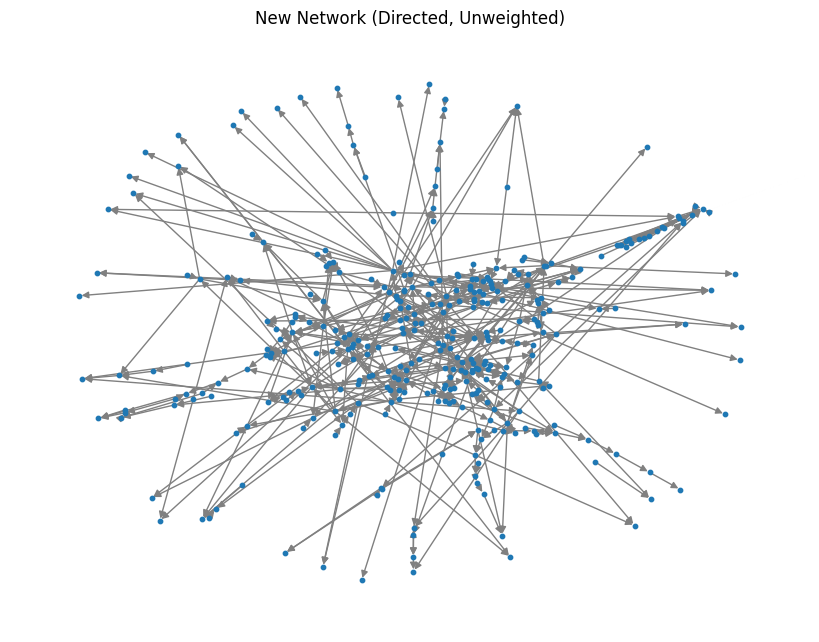

In [109]:
G = nx.DiGraph()  

with open("interactionsunique.csv", newline='') as f:
    reader = csv.reader(f)
    next(reader)  
    for row in reader:
        u, v = row  
        G.add_edge(int(u), int(v))

sorted_nodes = sorted(G.nodes())

pos = nx.spring_layout(G,seed=42)
print("Number of nodes:",len(G.nodes))
print("Number of edges:",nx.number_of_edges(G))
plt.figure(figsize=(8, 6))
nx.draw(G, pos,
        node_size=10,
        edge_color='gray')
plt.title("New Network (Directed, Unweighted)")
plt.show()

In [110]:
# Reading file with Node info
Node_meta={}
with open("nodes.txt", newline='') as f:
    for line in f:
        if ':' in line:
            value,key = line.strip().split(':')
            Node_meta[int(key)] = value

In [111]:
#Connected components
num_components = nx.number_weakly_connected_components(G)
strong_num_components=nx.number_strongly_connected_components(G)
print("Number of weakly connected components:", num_components) #1
print("Number of strongly connected components:", strong_num_components) #219

Number of weakly connected components: 1
Number of strongly connected components: 219


## Louvain Communities

In [112]:
nodes = list(G.nodes())
num_runs=20
max_modularity=0
community_max_modularity=[]
# Creating initial DataFrame with node IDs
df = pd.DataFrame({"Node": nodes})

for run in range(num_runs):
    louvaincommunities = nx.algorithms.community.louvain_communities(G)
    modularity_comm=nx.algorithms.community.modularity(G,louvaincommunities)
    if modularity_comm>max_modularity:
        max_modularity=modularity_comm
        community_max_modularity=np.copy(louvaincommunities)
    node_community = {}
    for i, comm in enumerate(louvaincommunities):
        for node in comm:
            node_community[node] = i

    df[f"Run {run+1}"] = df["Node"].map(node_community)

df.to_csv("louvain_communities_master.csv", index=False)

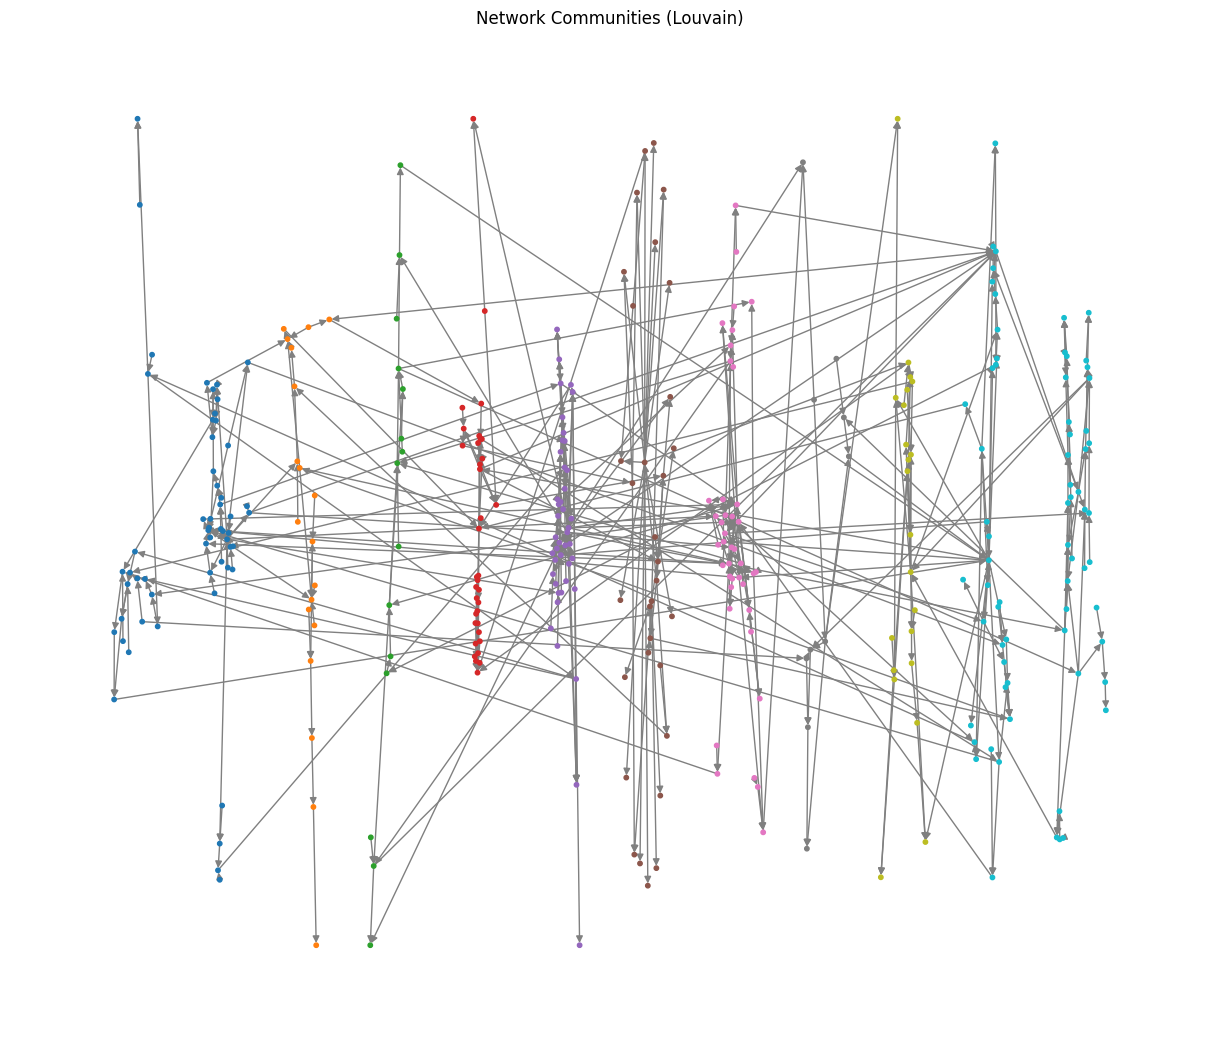

0.7264777437186141
12


In [113]:
# Map each node to its community index
node_community = {}
for i, comm in enumerate(community_max_modularity):
    for node in comm:
        node_community[node] = i

# Build positions: cluster each community separately, then offset them
pos = {}
cluster_spacing = 3  # distance between community centers
for i, comm in enumerate(community_max_modularity):
    subgraph = G.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, seed=42)
    offset = (i * cluster_spacing, 0)  # shift each cluster along x-axis
    for node, (x, y) in sub_pos.items():
        pos[node] = (x + offset[0], y + offset[1])

# Assign colors based on community
colors = [node_community[node] for node in G.nodes()]

# Draw
plt.figure(figsize=(12, 10))
nx.draw(
    G, pos,
    node_color=colors,
    node_size=10,
    cmap=plt.cm.tab10,
    edge_color='gray'
)

plt.title("Network Communities (Louvain)")
plt.axis('off')
plt.show()

print(max_modularity)
print(len(community_max_modularity))

## Leiden Communities

### Modularity

In [114]:
# Convert to igraph
G_ig = ig.Graph.TupleList(G.edges(), directed=False, vertex_name_attr="name")
index_to_name = G_ig.vs["name"]

nodes = list(G_ig.vs["name"])
df = pd.DataFrame({"Node": nodes})

num_runs = 20
max_modularity = -1
community_max_modularity = []

for run in range(num_runs):
    # Run Leiden
    leiden_partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)
    leiden_communities_named = [[index_to_name[i] for i in comm] for comm in leiden_partition]
    
    # Use Leiden’s own modularity measure
    modularity_comm = leiden_partition.quality()
    
    # Update best partition
    if modularity_comm > max_modularity:
        max_modularity = modularity_comm
        community_max_modularity = copy.deepcopy(leiden_communities_named)
    
    # Store run community assignments
    node_community = {}
    for i, comm in enumerate(leiden_communities_named):
        for node in comm:
            node_community[node] = i

    df[f"Run {run+1}"] = df["Node"].map(node_community)

# Add best modularity partition
node_community_best = {}
for i, comm in enumerate(community_max_modularity):
    for node in comm:
        node_community_best[node] = i

df["Best Modularity"] = df["Node"].map(node_community_best)

# Save
df.to_csv("leiden_communities_modularity_master.csv", index=False)


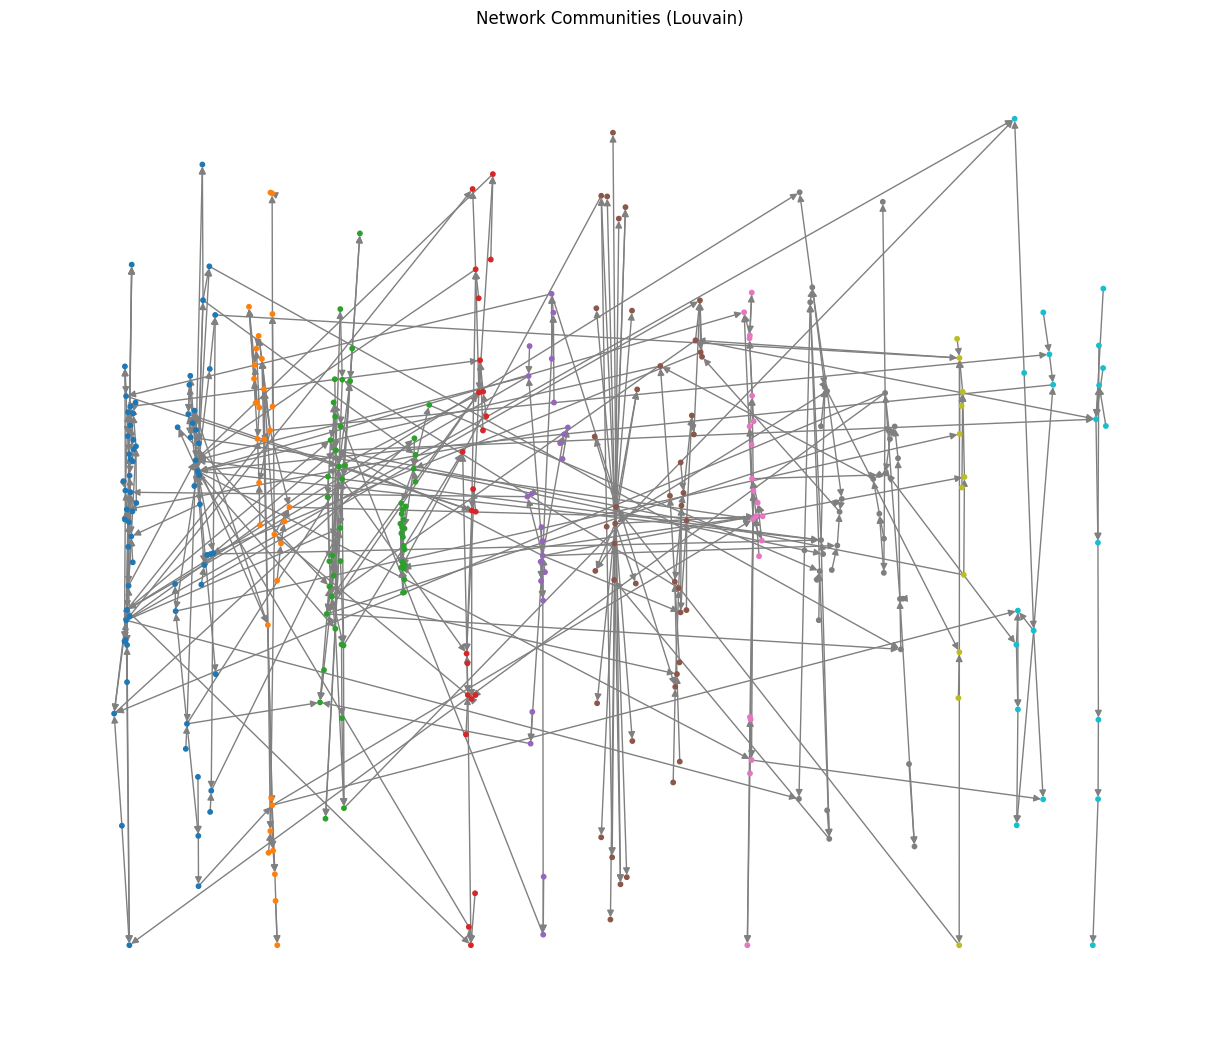

0.7304727852290981
15


In [115]:
# Map each node to its community index
node_community = {}
for i, comm in enumerate(community_max_modularity):
    for node in comm:
        node_community[node] = i

# Build positions: cluster each community separately, then offset them
pos = {}
cluster_spacing = 3  # distance between community centers
for i, comm in enumerate(community_max_modularity):
    subgraph = G.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, seed=42)
    offset = (i * cluster_spacing, 0)  # shift each cluster along x-axis
    for node, (x, y) in sub_pos.items():
        pos[node] = (x + offset[0], y + offset[1])

# Assign colors based on community
colors = [node_community[node] for node in G.nodes()]

# Draw
plt.figure(figsize=(12, 10))
nx.draw(
    G, pos,
    node_color=colors,
    node_size=10,
    cmap=plt.cm.tab10,
    edge_color='gray'
)

plt.title("Network Communities (Louvain)")
plt.axis('off')
plt.show()

print(max_modularity)
print(len(community_max_modularity))

### CPM

0.11473684210526315


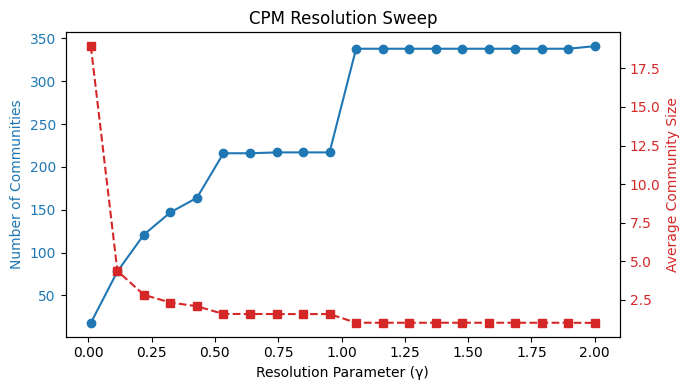

In [116]:
# --- Convert your NetworkX graph to igraph ---
# G is your NetworkX graph
G_ig = ig.Graph.TupleList(G.edges(), directed=False, vertex_name_attr="name")
index_to_name = G_ig.vs["name"]
# --- Define resolution range ---
resolutions = np.linspace(0.01, 2.0, 20)  # adjust range and steps if needed
print(resolutions[1])
num_communities = []
avg_comm_size = []

for gamma in resolutions:
    partition = leidenalg.find_partition(G_ig, leidenalg.CPMVertexPartition, resolution_parameter=gamma)
    num_communities.append(len(partition))
    # Compute average community size
    sizes = [len(c) for c in partition]
    avg_comm_size.append(np.mean(sizes))

# --- Plot results ---
fig, ax1 = plt.subplots(figsize=(7, 4))

color = 'tab:blue'
ax1.set_xlabel("Resolution Parameter (γ)")
ax1.set_ylabel("Number of Communities", color=color)
ax1.plot(resolutions, num_communities, marker='o', color=color, label="Num. Communities")
ax1.tick_params(axis='y', labelcolor=color)

# Second axis for avg community size
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Average Community Size", color=color)
ax2.plot(resolutions, avg_comm_size, marker='s', linestyle='--', color=color, label="Avg. Size")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("CPM Resolution Sweep")
fig.tight_layout()
plt.show()
plt.show()

In [146]:
# Convert to igraph
G_ig = ig.Graph.TupleList(G.edges(), directed=False, vertex_name_attr="name")
index_to_name = G_ig.vs["name"]

nodes = list(G_ig.vs["name"])
df = pd.DataFrame({"Node": nodes})

num_runs = 20
max_cpm = -1
community_max_cpm = []
compilation_time=0

for run in range(num_runs):
    # Run Leiden
    start_time=time.time()
    leiden_partition = leidenalg.find_partition(G_ig, leidenalg.CPMVertexPartition,resolution_parameter=0.01)
    end_time = time.time()
    compilation_time+= end_time - start_time

    leiden_communities_named = [[index_to_name[i] for i in comm] for comm in leiden_partition]
    
    # Use Leiden’s own CPM measure
    cpm_comm = leiden_partition.quality()
    
    # Update best partition
    if cpm_comm > max_cpm:
        max_cpm = cpm_comm
        community_max_cpm = copy.deepcopy(leiden_communities_named)
    
    # Store run community assignments
    node_community = {}
    for i, comm in enumerate(leiden_communities_named):
        for node in comm:
            node_community[node] = i

    df[f"Run {run+1}"] = df["Node"].map(node_community)

# Add best modularity partition
node_community_best = {}
for i, comm in enumerate(community_max_cpm):
    for node in comm:
        node_community_best[node] = i

df["Best Modularity"] = df["Node"].map(node_community_best)

compilation_time=compilation_time/20
print(f"Computation time: {compilation_time:.4f} seconds")
# Save
df.to_csv("leiden_communities_cpm_master.csv", index=False)

Computation time: 0.0014 seconds


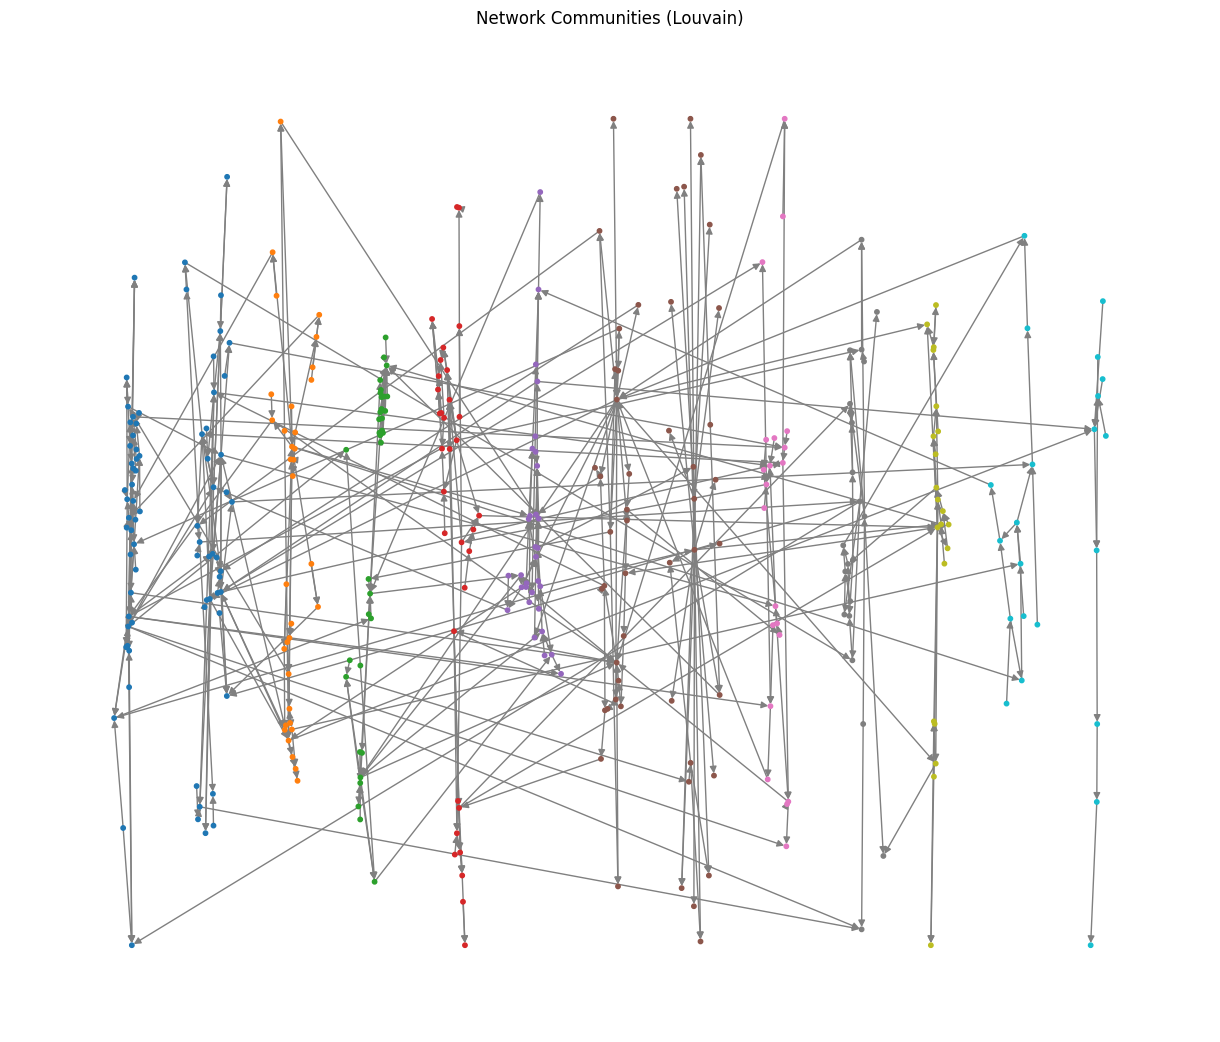

268.49999999999994
49


In [ ]:
# Map each node to its community index
node_community = {}
for i, comm in enumerate(community_max_modularity):
    for node in comm:
        node_community[node] = i

# Build positions: cluster each community separately, then offset them
pos = {}
cluster_spacing = 3  # distance between community centers
for i, comm in enumerate(community_max_modularity):
    subgraph = G.subgraph(comm)
    sub_pos = nx.spring_layout(subgraph, seed=42)
    offset = (i * cluster_spacing, 0)  # shift each cluster along x-axis
    for node, (x, y) in sub_pos.items():
        pos[node] = (x + offset[0], y + offset[1])

# Assign colors based on community
colors = [node_community[node] for node in G.nodes()]

# Draw
plt.figure(figsize=(12, 10))
nx.draw(
    G, pos,
    node_color=colors,
    node_size=10,
    cmap=plt.cm.tab10,
    edge_color='gray'
)

plt.title("Network Communities (Louvain)")
plt.axis('off')
plt.show()

print(constant_potts(G,leiden_communities_named,0.05))
print(len(community_max_cpm))

In [ ]:
# Convert to igraph
G_ig = ig.Graph.TupleList(G.edges(), directed=False, vertex_name_attr="name")
index_to_name = G_ig.vs["name"]

nodes = list(G_ig.vs["name"])
df = pd.DataFrame({"Node": nodes})

num_runs = 20
max_cpm = -1
community_max_cpm = []

for run in range(num_runs):
    # Run Leiden
    leiden_partition = leidenalg.find_partition(G_ig, leidenalg.CPMVertexPartition,resolution_parameter=0.05)
    leiden_communities_named = [[index_to_name[i] for i in comm] for comm in leiden_partition]
    
    # Use Leiden’s own CPM measure
    cpm_comm = leiden_partition.quality()
    
    # Update best partition
    if cpm_comm > max_cpm:
        max_cpm = cpm_comm
        community_max_cpm = copy.deepcopy(leiden_communities_named)
    
    # Store run community assignments
    node_community = {}
    for i, comm in enumerate(leiden_communities_named):
        for node in comm:
            node_community[node] = i

    df[f"Run {run+1}"] = df["Node"].map(node_community)

# Add best modularity partition
node_community_best = {}
for i, comm in enumerate(community_max_cpm):
    for node in comm:
        node_community_best[node] = i

df["Best Modularity"] = df["Node"].map(node_community_best)

# Save
df.to_csv("leiden_communities_rbm_master.csv", index=False)